In [1]:
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
import tikzplotlib
import sys
sys.path.insert(1, '/Users/bangun/pyptychostem')
from STEM4D import Data4D, SSB, WDD
from live_wdd.parameters import physical_coordinate
from libertem.common import Shape 
from scipy.ndimage import center_of_mass 
from live_wdd.dim_reduct import get_sampled_basis
#from live_wdd.live_wdd import probe_initial,pre_computed_Wiener,roi_wiener_filter,f2d_matrix_replacement,wdd_per_frame_combined
from live_wdd.live_wdd import prepare_livewdd
import time
import numpy as np

cannot load pixstem package...
4D plot not possible


In [3]:
#!/usr/bin/env python3

from STEM4D import Data4D, SSB, WDD
import numpy as np
import multiprocessing
#import hyperspy.api as hs
#%matplotlib tk
from live_wdd.wdd_udf import WDDUDF
import sys

In [4]:
from libertem.api import Context

In [5]:
list_dose = [1e2,1e3,1e4,1e5, -1]

In [6]:
path_idp_live='/Users/bangun/Dataset/Dataset_LiveWDD/idp_pyptycho_graphene_dose_'

In [7]:

# Create context
ctx = Context()

In [8]:
idp_dose = []
wdd_pyptycho_result = []
live_wdd_res = []
for add_dose in list_dose:
    try:
        import pixstem.api as ps
    except:
        print('cannot load pixstem package...')
        print('iCOM not possible')


    if len(sys.argv)==1:
        parfile = sys.argv[1]
    else:

        parfile = '/Users/bangun/pyptychostem/parameters.txt'
        
        
    #params = np.genfromtxt(parfile,delimiter='\t',dtype=str)
    
    par_dictionary = {}

    file = open(parfile)

    for line in file:
        if line.startswith('##'):
            continue
        split_line = line.rstrip().split('\t')
        print(split_line)

        if len(split_line)!=2:
            continue
        key, value = split_line
        par_dictionary[key] = value

        
        
    method = par_dictionary.get('method','wdd')   
    expansion_ratio = float(par_dictionary.get('CBED/BF',-1))
    dose = add_dose
    
    if  expansion_ratio<1:
        expansion_ratio = None
    save = int(par_dictionary.get('save',1))

    if method not in ['ssb','wdd','iCOM']:
        print('method not understood')


    data_4D = Data4D(parfile)
    
    data_4D.estimate_aperture_size() 
    path_idp_live
    
    if dose>0:
        print('Add dose: ', dose)
        data_4D.apply_dose(dose)
        
    data_4D.truncate_ronchigram(expansion_ratio=expansion_ratio) # crops ronchigram to area of interest
    
    
    data_4D.apply_FT()

    
    wdd = WDD(data_4D)
    wdd.run()
     
    wdd_result = wdd.Obj_function
    wdd_pyptycho = np.fft.fft2(np.fft.fft2(wdd_result))
    
    wdd_pyptycho_result.append(wdd_pyptycho)
    
    
    ## Live WDD
    ## Store the contaminated data for contex libertem
    dim = data_4D.data_4D.shape
    filepath = path_idp_live + str(dose) + '.raw'
    data_4D.data_4D.tofile(filepath)
                           
                   

    ds = ctx.load("raw", path=filepath, dtype=np.float32, nav_shape=(dim[0], dim[1]), sig_shape=(dim[2], dim[3]))  
    ds.set_num_cores(4*18)


    acc = float(par_dictionary['voltage'])# in kV
    scan_real = float(par_dictionary['stepsize'])*1e-1 # in nm
    semiconv=float(par_dictionary['aperture'])*1e3 # In mrad
    rad = data_4D.aperture_radius
    order = 16
    com = (data_4D.center_y,data_4D.center_x)

    # Live WDD
    complex_dtype = np.complex64
    scan_idx, wiener_filter_compressed,row_exp, col_exp,coeff = prepare_livewdd(ds.shape, acc, scan_real, 
                                                                                semiconv, rad, com, order, 
                                                                                complex_dtype,ctx,ds)

    complex_dtype = np.complex64
    live_wdd = ctx.run_udf(dataset=ds, roi = None,
                           udf= WDDUDF(wiener_filter_compressed, scan_idx, coeff, 
                                       row_exp, col_exp,complex_dtype))

    live_wdd_recon = live_wdd['reconstructed']
    live_wdd_res.append(np.array(live_wdd_recon))

cannot load pixstem package...
iCOM not possible
['file', '/Users/bangun/Dataset/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['#file', '/Local/erc-1/bangun/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['method', 'wdd']
['aperture', '0.03']
['stepsize', '0.2']
['voltage', '60.0']
['rotation', '0.0']
['']
['']
['threshold', '0.3']
['workers', '1']
['CBED/BF', '-1']
['dose -1']
['']
['plot_4D', '1']
['plot_4D_reciprocal', '1']
['plot_aperture', '1']
['plot_result', '1']
['plot_trotters', '1']
['plot_power_spectrum', '1']
['']
['save', '1']
['#dose', '50']
['file', '/Users/bangun/Dataset/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['#file', '/Local/erc-1/bangun/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['method', 'wdd']
['aperture', '0.03']
['stepsize', '0.2']
['voltage', '60.0']
['rotation', '0.0']
['']
['']
['threshold', '0.3']
['workers', '1']
['CBED/BF', '-1']
['dose -1']
['']
['plot_4D', '1']
['plot_4D_reciprocal', '1']
['plot_aperture', '1']
['plot_result', '

In [9]:
result_pyptycho = np.array(wdd_pyptycho_result).astype(np.complex64)
result_livewdd = np.array(live_wdd_res)

## Plot Reconstruction for Infinite Dose

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

<IPython.core.display.Javascript object>


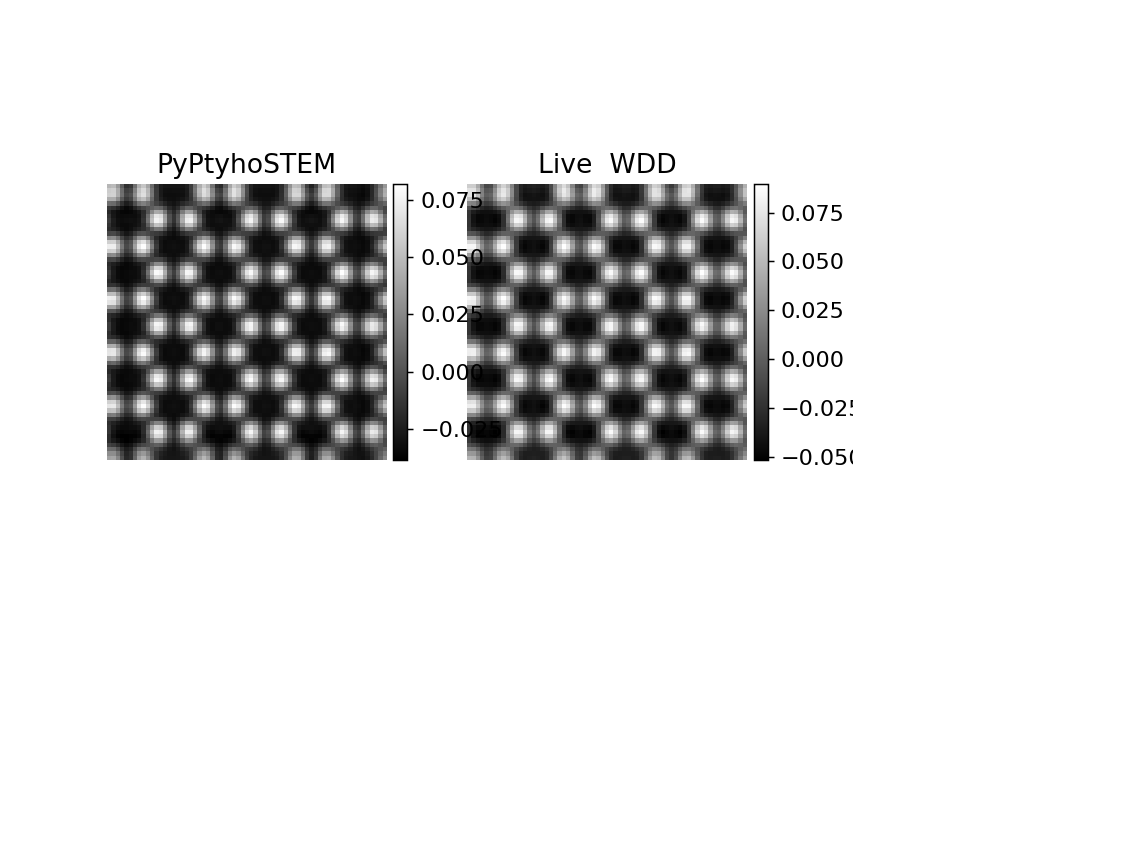

In [11]:

fig,(ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
im1 = ax1.imshow(np.angle(result_pyptycho[-1]),cmap = 'gray')
im2 = ax2.imshow(np.angle(result_livewdd[-1]),cmap = 'gray')
ax1.set_axis_off()
ax1.set_title('PyPtyhoSTEM')
ax2.set_axis_off()
ax2.set_title('Live  WDD')
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')


## Plot Reconstruction for Different Doses

<IPython.core.display.Javascript object>


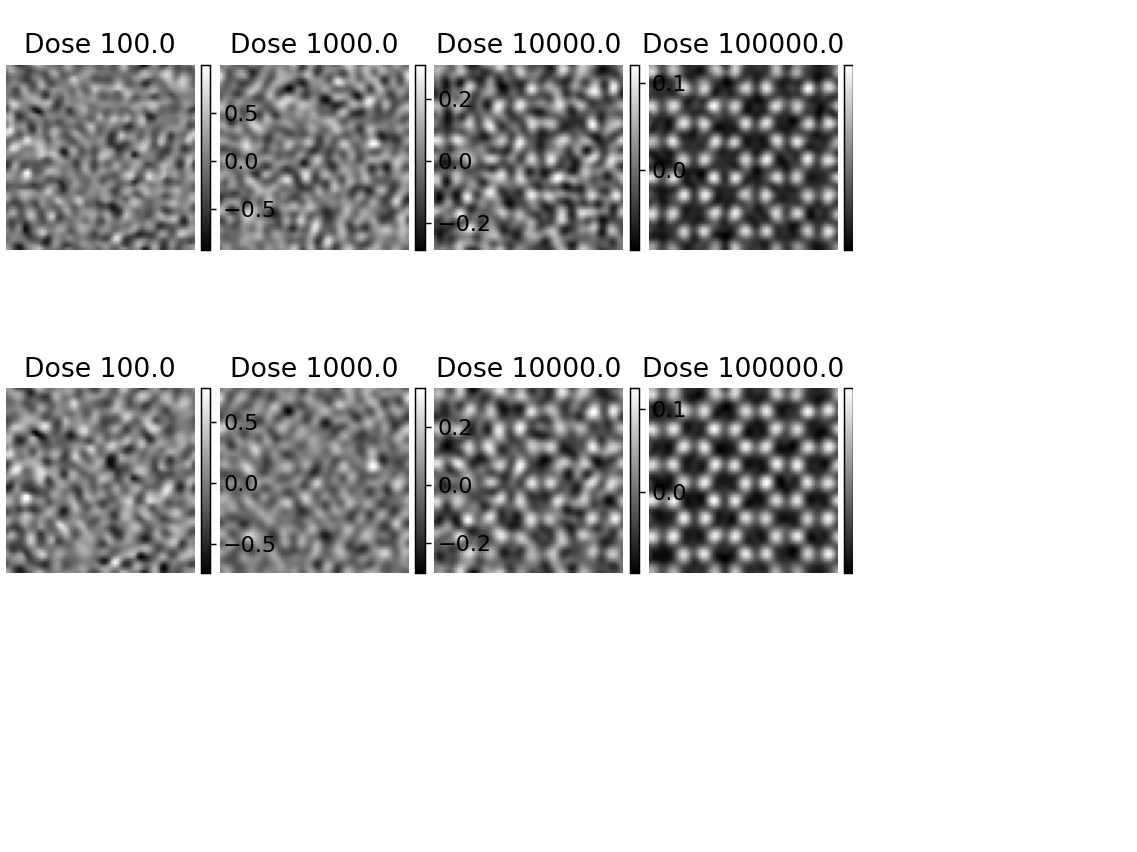

In [12]:
fig,ax = plt.subplots(2,len(list_dose)-1,constrained_layout=True, sharex=True, sharey=True)
 
for each_dose in range(len(list_dose)-1):
    
    # Conventional WDD
    im1 = ax[0,each_dose].imshow(np.angle(result_pyptycho[each_dose]),cmap = 'gray')
    divider = make_axes_locatable(ax[0,each_dose])
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    ax[0,each_dose].set_axis_off()
    ax[0,each_dose].set_title('Dose ' + str(list_dose[each_dose]))
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    
    # Live Proc WDD
    im2 = ax[1,each_dose].imshow(np.angle(result_livewdd[each_dose]),cmap = 'gray')
    divider = make_axes_locatable(ax[1,each_dose])
    cax2 = divider.append_axes('right', size='5%', pad=0.05)
    ax[1,each_dose].set_axis_off()
    ax[1,each_dose].set_title('Dose ' + str(list_dose[each_dose]))
    fig.colorbar(im2, cax=cax2, orientation='vertical')

## Check specific Dose (10^4)

In [13]:
idx_dose = 2

In [14]:
wdd_dose = np.angle(result_pyptycho[idx_dose])
live_wdd_dose = np.angle(result_livewdd[idx_dose])
wdd_dose_inf = np.angle(result_pyptycho[-1])
live_wdd_dose_inf = np.angle(result_livewdd[-1])

In [15]:
idx_y = 32
yy = [idx_y,idx_y]
xx = [0, 64]
pyptycho=wdd_dose[idx_y,:]
lwdd = live_wdd_dose[idx_y,:]
pyptycho_inf_dose = wdd_dose_inf[idx_y,:]
lwdd_inf = live_wdd_dose_inf[idx_y,:]


In [16]:
lb = np.min((np.min((np.min(pyptycho), np.min(lwdd))), np.min((np.min(pyptycho_inf_dose), np.min(lwdd_inf)))))
ub = np.max((np.max((np.max(pyptycho),np.max(lwdd))), np.max((np.max(pyptycho_inf_dose),np.max(lwdd_inf)))))

<IPython.core.display.Javascript object>


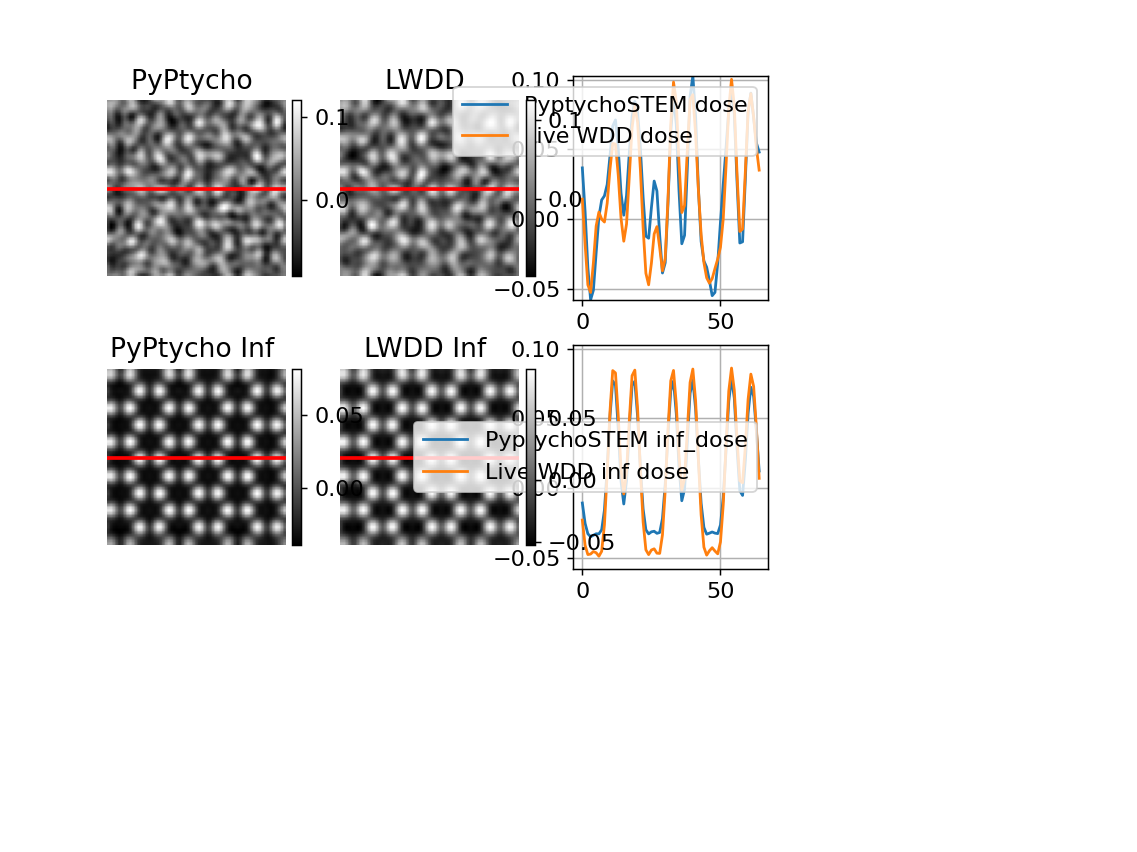

(-0.05785118043422699, 0.10285281389951706)

In [19]:
fig, ((ax1,ax2,ax3),
      (ax4,ax5,ax6))= plt.subplots(2,3)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
#divider3 = make_axes_locatable(ax3)
#cax3 = divider3.append_axes('right', size='5%', pad=0.05)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='5%', pad=0.05)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('right', size='5%', pad=0.05)
#divider6 = make_axes_locatable(ax6)
#cax6 = divider6.append_axes('right', size='5%', pad=0.05)




im1 = ax1.imshow(wdd_dose, cmap = 'gray')
ax1.plot(xx,yy, color="red", linewidth=2)
ax1.set_axis_off()
ax1.set_title('PyPtycho ')
fig.colorbar(im1, cax=cax1, orientation='vertical')

im2 = ax2.imshow(live_wdd_dose, cmap = 'gray')
ax2.plot(xx,yy, color="red", linewidth=2)
ax2.set_axis_off()
ax2.set_title('LWDD ')
fig.colorbar(im2, cax=cax2, orientation='vertical')


im4 = ax4.imshow(wdd_dose_inf, cmap = 'gray')
ax4.plot(xx,yy, color="red", linewidth=2)
ax4.set_axis_off()
ax4.set_title('PyPtycho Inf ')
fig.colorbar(im4, cax=cax4, orientation='vertical')

im5 = ax5.imshow(live_wdd_dose_inf, cmap = 'gray')
ax5.plot(xx,yy, color="red", linewidth=2)
ax5.set_axis_off()
ax5.set_title('LWDD Inf ')
fig.colorbar(im5, cax=cax5, orientation='vertical')



ax3.plot(pyptycho, label= 'PyptychoSTEM dose')
ax3.plot(lwdd, label = 'Live WDD dose')
ax6.plot(pyptycho_inf_dose, label = 'PyptychoSTEM inf_dose')
ax6.plot(lwdd_inf, label = 'Live WDD inf dose')
ax3.grid(True)
ax6.grid(True)

ax3.legend()
ax6.legend()
ax3.set_ylim([lb,ub ])
ax6.set_ylim([lb,ub ])

In [20]:
xgrid = np.arange(len(pyptycho))

<IPython.core.display.Javascript object>


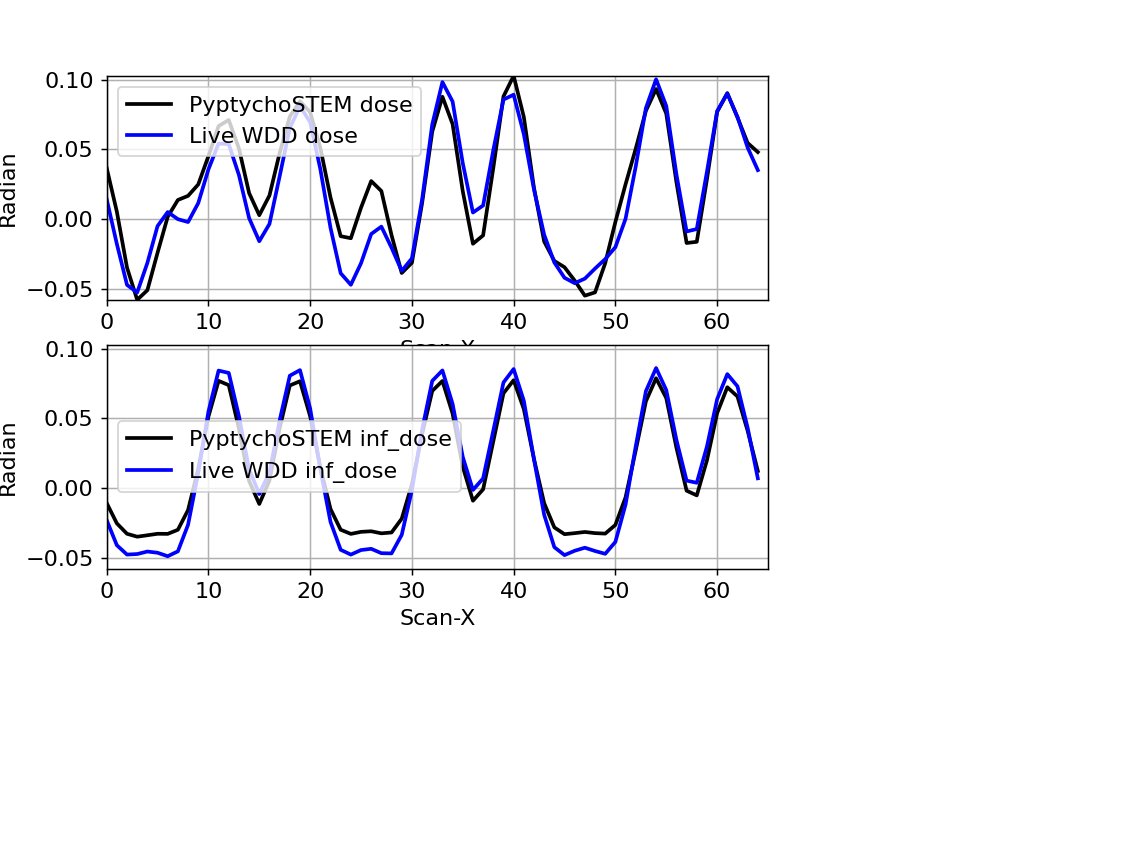

(-0.05785118043422699, 0.10285281389951706)

In [21]:
fig, (ax3,ax6) = plt.subplots(2,1)
ax3.plot(xgrid,pyptycho, '-k', label= 'PyptychoSTEM dose', linewidth = 2)
ax3.plot(xgrid,lwdd, '-b',label = 'Live WDD dose', linewidth = 2)
ax6.plot(xgrid,pyptycho_inf_dose, '-k', label = 'PyptychoSTEM inf_dose', linewidth = 2)
ax6.plot(xgrid,lwdd_inf, '-b', label = 'Live WDD inf_dose', linewidth = 2)
ax3.grid(True)
ax6.grid(True)

#ax3.legend()
#ax6.legend()
#ax3.set_ylim([lb,ub ])
#ax6.set_ylim([lb,ub ])
ax3.set_ylabel('Radian')
ax3.set_xlabel('Scan-X')
ax3.legend()
ax3.set_xlim([0,len(xgrid)])
ax3.set_ylim([lb,ub])


ax6.set_ylabel('Radian')
ax6.set_xlabel('Scan-X')
ax6.legend()
ax6.set_xlim([0,len(xgrid)])
ax6.set_ylim([lb,ub])